<a href="https://colab.research.google.com/github/Frostbite22/learning-DL-by-doing-2/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
from google.colab import drive

drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/PyTorch/learning_DL2/")

Mounted at /content/drive


In [11]:
import zipfile
from pathlib import Path

data_path = Path('/data')
image_path = data_path / "images"

if image_path.is_dir():
  print(f'{image_path} directory already exists')
else:
  print(f"{image_path} doesn't exist, creating one ...")
  image_path.mkdir(parents=True,exist_ok=True)

with zipfile.ZipFile('hymenoptera_data.zip','r') as zip_ref:
  zip_ref.extractall(image_path)

/data/images directory already exists


In [12]:
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")


In [13]:
walk_through_dir(image_path)

There are 1 directories and 0 images in /data/images
There are 2 directories and 0 images in /data/images/hymenoptera_data
There are 2 directories and 0 images in /data/images/hymenoptera_data/val
There are 0 directories and 83 images in /data/images/hymenoptera_data/val/bees
There are 0 directories and 70 images in /data/images/hymenoptera_data/val/ants
There are 2 directories and 0 images in /data/images/hymenoptera_data/train
There are 0 directories and 121 images in /data/images/hymenoptera_data/train/bees
There are 0 directories and 124 images in /data/images/hymenoptera_data/train/ants


In [16]:
os.getcwd()

'/content/drive/MyDrive/PyTorch/learning_DL2'

In [29]:
train_dir = image_path / "hymenoptera_data/train"
val_dir = image_path / "hymenoptera_data/val"


random img path: /data/images/hymenoptera_data/train/ants/484293231_e53cfc0c89.jpg
image class : ants
Image height: 397
image width: 500


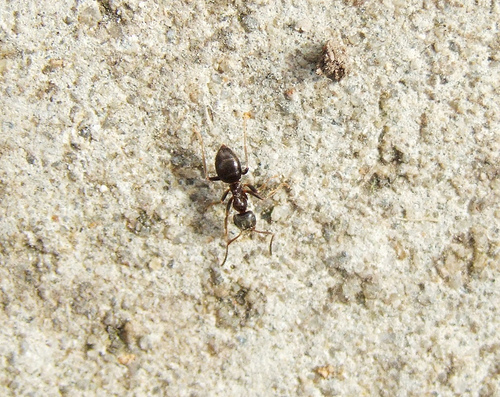

In [19]:
#Visualizing an image  
import random 
from PIL import Image 

# set seed 
random.seed(42)

#1. get all image paths 
image_path_list = list(image_path.glob("*/*/*/*.jpg"))
#2. pick a random image path 
random_image_path = random.choice(image_path_list)
#3. get image class from the path name(is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
#4. open image 
img = Image.open(random_image_path)
#5. print metadata 
print(f"random img path: {random_image_path}")
print(f"image class : {image_class}")
print(f"Image height: {img.height}")
print(f"image width: {img.width}")
img

Text(0.5, 1.0, 'image class : ants | Image Shape : (397, 500, 3) -> [height,width,color_channels]')

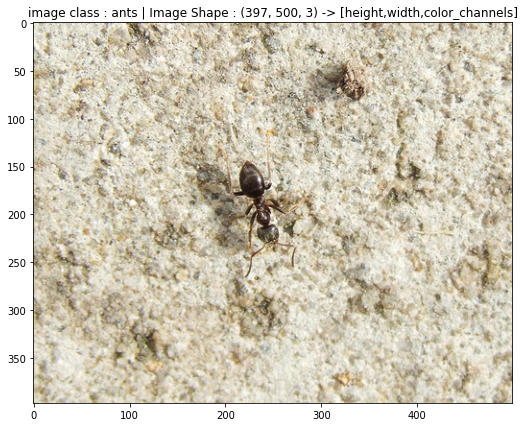

In [25]:
import numpy as np 
import matplotlib.pyplot as plt 

#Turn image to an array 
image_as_array = np.asarray(img)

#Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(image_as_array)
plt.title(f"image class : {image_class} | Image Shape : {image_as_array.shape} -> [height,width,color_channels]")

In [26]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_transforms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val' : transforms.Compose([
        transforms.Resize(226),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

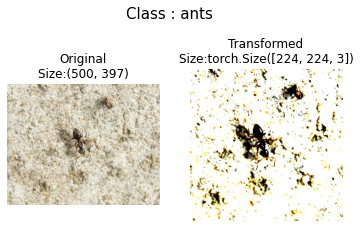

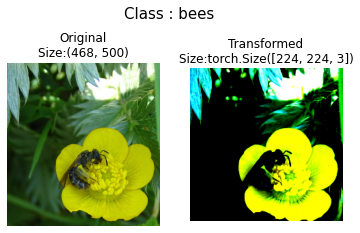

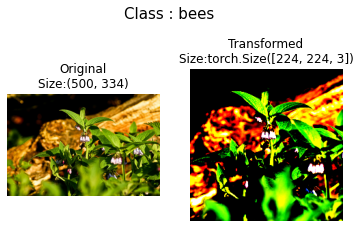

In [51]:
def plot_transformed_images(image_paths,transform,n=3,seed=42):
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths,k=n)
  for image_path in random_image_paths: 
    with Image.open(image_path) as f:
      fig,ax = plt.subplots(nrows=1,ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize:{f.size}")
      ax[0].axis(False)
      ## transformed image
      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nSize:{transformed_image.shape}")
      ax[1].axis(False)
      fig.suptitle(f'Class : {image_path.parent.stem}',fontsize=15)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transforms['val'])

In [30]:
train_dataset = datasets.ImageFolder(root=train_dir,
                                     transform=data_transforms['train'])

val_dataset = datasets.ImageFolder(root=val_dir,
                                     transform=data_transforms['val'])

In [46]:
len(train_dataset),len(val_dataset)

(244, 153)

In [37]:
class_names = train_dataset.classes
class_names

['ants', 'bees']

In [33]:
img,label = train_dataset[0]

Text(0.5, 1.0, "the label of this image is ants and it's shape is torch.Size([3, 224, 224]) -> [color_channels,width,height]")

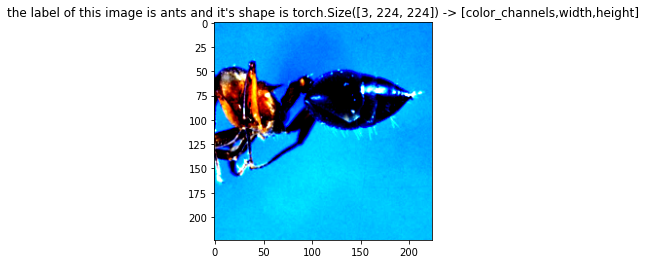

In [39]:
plt.imshow(img.permute(1,2,0))
plt.title(f"the label of this image is {class_names[label]} and it's shape is {img.shape} -> [color_channels,width,height]")

In [40]:
img, label = val_dataset[0]

Text(0.5, 1.0, "the label of this image is ants and it's shape is torch.Size([3, 224, 224]) -> [color_channels,width,height]")

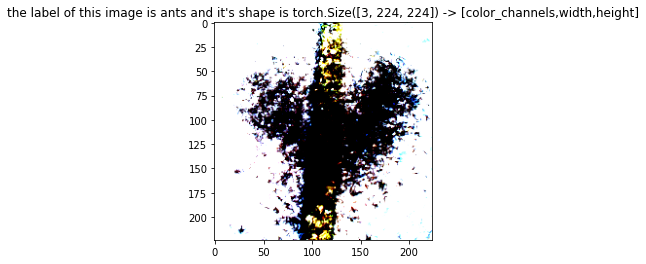

In [41]:
plt.imshow(img.permute(1,2,0))
plt.title(f"the label of this image is {class_names[label]} and it's shape is {img.shape} -> [color_channels,width,height]")

In [65]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=4,
                              shuffle=True,
                              num_workers=1)

val_dataloader = DataLoader(dataset=val_dataset,
                              batch_size=4,
                              shuffle=False,
                              num_workers=1)


dataloaders = {'train': DataLoader(dataset=train_dataset,
                              batch_size=4,
                              shuffle=True,
                              num_workers=1),
               'val' : DataLoader(dataset=val_dataset,
                              batch_size=4,
                              shuffle=False,
                              num_workers=1)}

dataset_sizes = {'train': len(train_dataset),
                 'val' : len(val_dataset)}


In [66]:
len(train_dataloader), len(val_dataloader)

(61, 39)

In [67]:
img, label = next(iter(train_dataloader))

print(f'Image Shape: {img.shape} -> [batch_size,color_channels,height,width]')
print(f'Label Shape: {label.shape}')

Image Shape: torch.Size([4, 3, 224, 224]) -> [batch_size,color_channels,height,width]
Label Shape: torch.Size([4])


In [69]:
import time
import copy 
from torch.optim import lr_scheduler
from torchvision import models

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [71]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [72]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)


Epoch 0/24
----------
train Loss: 0.7082 Acc: 0.6475
val Loss: 0.5921 Acc: 0.7516

Epoch 1/24
----------
train Loss: 0.5687 Acc: 0.7459
val Loss: 0.2317 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.3645 Acc: 0.8402
val Loss: 0.3609 Acc: 0.8301

Epoch 3/24
----------
train Loss: 0.4548 Acc: 0.8607
val Loss: 0.2745 Acc: 0.8954

Epoch 4/24
----------
train Loss: 0.5213 Acc: 0.7828
val Loss: 0.2941 Acc: 0.8954

Epoch 5/24
----------
train Loss: 0.5707 Acc: 0.7705
val Loss: 0.5540 Acc: 0.8170

Epoch 6/24
----------
train Loss: 0.4760 Acc: 0.7910
val Loss: 0.3600 Acc: 0.8627

Epoch 7/24
----------
train Loss: 0.3326 Acc: 0.8566
val Loss: 0.2423 Acc: 0.8954

Epoch 8/24
----------
train Loss: 0.3980 Acc: 0.8238
val Loss: 0.2261 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.3877 Acc: 0.8320
val Loss: 0.2160 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.2974 Acc: 0.8607
val Loss: 0.2614 Acc: 0.8889

Epoch 11/24
----------
train Loss: 0.2929 Acc: 0.8770
val Loss: 0.2059 Acc: 0.9216

Ep